# Setup #

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from PIL import Image

2023-05-20 23:30:29.168429: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-20 23:30:29.211028: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 23:30:29.918185: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/rz95/miniconda3/envs/ee/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightl

# Data Loading #

Tuning:
1. Imitate model architecture of existing networks e.g. VGG, ResNet
2. Data Augmentation for monet images

In [2]:
MONET_IMAGES = tf.io.gfile.glob("./monet_jpg/*.jpg")
MONET_2_IMAGES = tf.io.gfile.glob("./monet_berkeley/*.jpg")
PHOTO_IMAGES = tf.io.gfile.glob("./photo_jpg/*.jpg")

In [3]:
MONET_MORE_IMAGES = MONET_IMAGES+MONET_2_IMAGES

In [4]:
# Normalize all the values to be between -1 and 1
def decode_image(images):
    decoded_images = []
    for image in images:
        image = np.asarray(Image.open(image)).astype("float32")
        image = tf.convert_to_tensor(image) # numpy -> tensor
        shape = image.shape
        image = tf.cast(image, tf.float32) / 127.5 - 1
        image = tf.reshape(image, shape)
        decoded_images.append(image)
    return decoded_images

In [5]:
monet_decoded = decode_image(MONET_MORE_IMAGES)
photo_decoded = decode_image(PHOTO_IMAGES)
# need to specify batch size for training subsequent models
monet_ds = tf.data.Dataset.from_tensor_slices(monet_decoded).batch(1) # list -> dataset
photo_ds = tf.data.Dataset.from_tensor_slices(photo_decoded).batch(1)

2023-05-20 23:30:32.853388: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
print("Monet files:", len(monet_ds))
print("Photo files: ", len(photo_ds))

Monet files: 1493
Photo files:  7038


In [7]:
monet_example = next(iter(monet_ds))
photo_example = next(iter(photo_ds))

2023-05-20 23:30:53.442228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1493,256,256,3]
	 [[{{node Placeholder/_0}}]]
2023-05-20 23:30:57.484184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [7038,256,256,3]
	 [[{{node Placeholder/_0}}]]


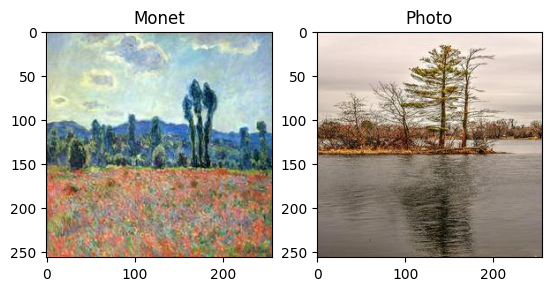

In [8]:
plt.subplot(1,2,1)
plt.title("Monet")
plt.imshow((monet_example[0]+1)/2)

plt.subplot(1,2,2)
plt.title("Photo")
plt.imshow((photo_example[0]+1)/2)

# Data Augmentation #

In [9]:
def data_augmentations():
    model = keras.Sequential()    
    rotation = random.random()
    if rotation<0.3:
        model.add(layers.RandomRotation(factor=(0.5,0.5)))
    elif rotation<0.6:
        model.add(layers.RandomRotation(factor=(1,1)))
    else:
        model.add(layers.RandomRotation(factor=(-0.5,-0.5)))
    flip = random.random()
    if flip<0.3:
        model.add(layers.RandomFlip(mode="horizontal"))
    elif flip<0.6:
        model.add(layers.RandomFlip(mode="vertical"))
    else:
        model.add(layers.RandomFlip(mode="horizontal_and_vertical"))
    model.add(layers.RandomCrop(224, 224, 3))
    model.add(layers.Resizing(256, 256))
    return model

In [10]:
augmented = []
for monet in monet_ds:
    augmented.append(data_augmentations()(monet))
aug_monet_ds = tf.data.Dataset.from_tensor_slices(augmented).unbatch().batch(1)
aug_monet_ds

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [11]:
print(len(augmented))

1493


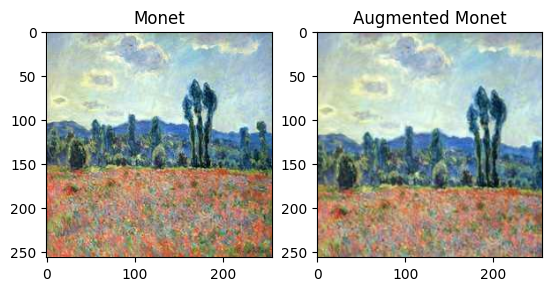

In [12]:
plt.subplot(1,2,1)
plt.title("Monet")
plt.imshow((monet_example[0]+1)/2)

plt.subplot(1,2,2)
plt.title("Augmented Monet")
plt.imshow((data_augmentations()(monet_example)[0]+1)/2)

# Generator #

Our generator is based on a U-Net architecture. A U-Net has a contracting path is composed of a series of convolutional and pooling layers that reduce the spatial dimensionality of the input image while increasing its depth. This helps in extracting high-level features and capturing context from the input image. A U-Net also has an expansive path is composed of a series of upsampling and concatenation operations, followed by convolutional layers that gradually increase the spatial dimensionality of the output. This helps in preserving the localization information and generating high-resolution segmentation maps.

Tuning:
1. Value of dropout, a number between 0.2 and 0.5
2. Dropout applying to more layers, or both contractive and expansive paths 
3. Addition of max / average pooling layers and upsampling as in https://arxiv.org/pdf/1505.04597.pdf

In [13]:
def downsample(num_filter, kernel_size, strides=2, instance_norm=False, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02) #initializer = keras.initializers.GlorotUniform
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    model = keras.Sequential()
    model.add(layers.Conv2D(num_filter, kernel_size, strides=strides, padding="same", kernel_initializer=initializer, use_bias=False))
    # Usually applied to style transfer, as the network needs to learn to represent the style or appearance of the input image, 
    # and the global statistics provided by batch normalization may not be appropriate. 
    # Normalization in general imporves training stability and more efficient backpropogation.
    if instance_norm:
        model.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    # Prevents dying neuron and 0 gradient, allowing a small output for negative input values
    if apply_dropout:
        model.add(layers.Dropout(0.2))
    model.add(layers.LeakyReLU()) 
    return model

In [14]:
def upsample(num_filter, kernel_size, strides=2, instance_norm=False, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    model = keras.Sequential()
    model.add(layers.Conv2DTranspose(num_filter, kernel_size, strides=strides, padding="same", kernel_initializer=initializer, use_bias=False))
    if instance_norm:
        model.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    # prevents overfitting and improves generalization
    if apply_dropout:
        model.add(layers.Dropout(0.2))
    model.add(layers.ReLU()) 
    return model

In [15]:
# def generator():
#     inputs = layers.Input(shape=[256,256,3])

#     # bs = batch size
#     down_stack = [
#         downsample(64, 4), # (bs, 128, 128, 64)
#         downsample(128, 4, instance_norm=True), # (bs, 64, 64, 128)
#         downsample(256, 4, instance_norm=True), # (bs, 32, 32, 256)
#         downsample(512, 4, instance_norm=True), # (bs, 16, 16, 512)
#         downsample(512, 4, instance_norm=True), # (bs, 8, 8, 512)
#         downsample(512, 4, instance_norm=True), # (bs, 4, 4, 512)
#         downsample(512, 4, instance_norm=True), # (bs, 2, 2, 512)
#         downsample(512, 4, instance_norm=True), # (bs, 1, 1, 512)
#     ]

#     up_stack = [
#         upsample(512, 4, instance_norm=True, apply_dropout=True), # (bs, 2, 2, 1024)
#         upsample(512, 4, instance_norm=True, apply_dropout=True), # (bs, 4, 4, 1024)
#         upsample(512, 4, instance_norm=True, apply_dropout=True), # (bs, 8, 8, 1024)
#         upsample(512, 4, instance_norm=True), # (bs, 16, 16, 1024)
#         upsample(256, 4, instance_norm=True), # (bs, 32, 32, 512)
#         upsample(128, 4, instance_norm=True), # (bs, 64, 64, 256)
#         upsample(64, 4, instance_norm=True), # (bs, 128, 128, 128)
#     ]

#     initializer = tf.random_normal_initializer(0., 0.02)
#     last = layers.Conv2DTranspose(3, 4,
#                                   strides=2,
#                                   padding='same',
#                                   kernel_initializer=initializer,
#                                   activation='tanh') # (bs, 256, 256, 3)

#     x = inputs

#     # Downsampling through the model
#     skips = []
#     for down in down_stack:
#         x = down(x)
#         skips.append(x)

#     skips = reversed(skips[:-1]) 

#     # Upsampling and establishing the skip connections
#     for up, skip in zip(up_stack, skips):
#         x = up(x)
#         x = layers.Concatenate()([x, skip])

#     x = last(x)

#     return keras.Model(inputs=inputs, outputs=x)

In [16]:
# # vgg inspired
# def generator():
#     # more complex data requires more number of kernels
#     down_stack = [
#         # instance normalization might interfere with learning of low-level features in the earlier layer
#         downsample(16, 3, strides=1), # (256, 256, 16)
#         downsample(16, 3, strides=1, instance_norm=True), # (256, 256, 16)
#         layers.MaxPool2D(), # (128, 128, 16)
#         downsample(32, 3, strides=1, instance_norm=True), # (128, 128, 32)
#         downsample(32, 3, strides=1, instance_norm=True), # (128, 128, 32)
#         layers.MaxPool2D(), # (64, 64, 32)
#         downsample(64, 3, strides=1, instance_norm=True), # (64, 64, 64)
#         downsample(64, 3, strides=1, instance_norm=True), # (64, 64, 64)
#         layers.MaxPool2D(), # (32, 32, 64)
#         downsample(128, 3, strides=1, instance_norm=True), # (32, 32, 128)
#         downsample(128, 3, strides=1, instance_norm=True) # (32, 32, 128)
#     ]
    
#     up_stack = [
#         upsample(128, 3, instance_norm=True, apply_dropout=True), # (64, 64, 128)
#         downsample(64, 3, strides=1, instance_norm=True), # (64, 64, 64)
#         downsample(64, 3, strides=1, instance_norm=True), # (64, 64, 64)
#         upsample(64, 3, instance_norm=True), # (128, 128, 64)
#         downsample(64, 3, strides=1, instance_norm=True), # (128, 128, 64)
#         downsample(64, 3, strides=1, instance_norm=True), # (128, 128, 64)
#         upsample(48, 3, instance_norm=True), # (256, 256, 48)
#         downsample(64, 3, strides=1, instance_norm=True), #(256, 256, 64)
#         downsample(64, 3, strides=1, instance_norm=True) #(256, 256, 64)
#     ]
    
#     inputs = layers.Input(shape=[256,256,3])
#     x = inputs
    
#     # Skip connections address the degradation problem (overfitting and vanishing / exploding gradients with deep neural nets),
#     # ensures feature reusability
#     skips = []
#     for i, down in enumerate(down_stack):
#         x = down(x)
#         if i==1 or i==4 or i==7:
#             skips.append(x)
        
#     skips = list(reversed(skips))
    
#     for j, up in enumerate(up_stack):
#         x = up(x)
#         if j==0 or j==3 or j==6:
#             x = layers.Concatenate()([skips[j//3], x]) 

#     last = layers.Conv2D(3, 1, strides=1, padding="same")
#     x = last(x)
    
#     return keras.Model(inputs=inputs, outputs=x)

In [17]:
# increase depth of model
# multiple kinds of abstractions for feature maps instead of very high-level abstractions
def generator():
    # more complex data requires more number of kernels
    down_stack = [
        # instance normalization might interfere with learning of low-level features in the first layer
        downsample(64, 3, strides=1), # (256, 256, 64)
        downsample(128, 3, instance_norm=True), # (128, 128, 128)
        downsample(256, 3, instance_norm=True), # (64, 64, 256)
        downsample(256, 3, strides=1, instance_norm=True), # (64, 64, 256)
        downsample(256, 3, strides=1, instance_norm=True), # (64, 64, 256)
        downsample(256, 3, strides=1, instance_norm=True), # (64, 64, 256)
        downsample(256, 3, strides=1, instance_norm=True), # (64, 64, 256)
        downsample(256, 3, strides=1, instance_norm=True) # (64, 64, 256)
    ]
    
    up_stack = [
        upsample(128, 3, instance_norm=True, apply_dropout=True), # (128, 128, 128)
        upsample(64, 3, instance_norm=True) # (256, 256, 64)
    ]
    
    # Using tanh to get output between -1 and 1, improves stability and convergence of training in GAN
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 3, strides=1, padding="same", kernel_initializer=initializer, activation="tanh") # (256, 256, 3)
    
    inputs = layers.Input(shape=[256,256,3])
    x = inputs
    
    # Skip connections address the degradation problem (overfitting and vanishing / exploding gradients with deep neural nets),
    # ensures feature reusability
    skips = []
    for i, down in enumerate(down_stack):
        x = down(x)
        if i==0 or i==1:
            skips.append(x)
        
    skips = list(reversed(skips))
    
    for skip, up in zip(skips, up_stack):
        x = up(x)
        x = layers.Concatenate()([skip, x]) 

    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x)

# Discriminator #

The discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

Tuning: 
1. Value for / add dropout
2. Whether output a smaller image or a single 0 or 1 value

In [18]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    input = layers.Input(shape=[256, 256, 3]) 
    x = input
    x = downsample(64, 4)(x) # (128, 128, 64)
    x = downsample(128, 4, instance_norm=True)(x) # (64, 64, 128)
    x = downsample(256, 4, instance_norm=True)(x) # (32, 32, 256)
    # zero padding prevents the border information from being lost
    x = layers.ZeroPadding2D()(x) # (34, 34, 256)
    # output size = (input size - kernel size)/stride + 1
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x) # (31, 31, 512)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    # activation usually happens after normalization
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x) # (32, 32, 512)
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x) # (30, 30, 1)
    return keras.Model(inputs=input, outputs=x)

# Model Initialization #

In [19]:
monet_generator = generator()
photo_generator = generator()
monet_discriminator = discriminator()
photo_discriminator = discriminator()

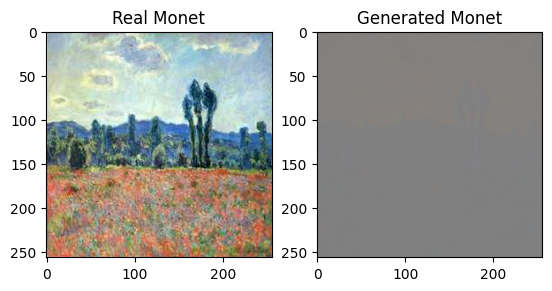

In [20]:
generated_monet_example = monet_generator(monet_example)

plt.subplot(1,2,1)
plt.title("Real Monet")
plt.imshow((monet_example[0]+1)/2)

plt.subplot(1,2,2)
plt.title("Generated Monet")
plt.imshow((generated_monet_example[0]+1)/2)

# CycleGAN Model #

Tuning:
1. Value of LAMBDA, a number between 5 and 10
2. Wasserstein Loss instead of binary cross entropy loss 

In [21]:
class CycleGAN(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10
    ):
        # override model class methods
        super(CycleGAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lbd = lambda_cycle
        
    def compile(
        self, 
        monet_generator_optimizer,
        photo_generator_optimizer,
        monet_discriminator_optimzer,
        photo_discriminator_optimizer, 
        generator_loss, 
        discriminator_loss, 
        cycle_gan_loss,
        identity_loss
    ):
        super(CycleGAN, self).compile()
        self.m_gen_opt = monet_generator_optimizer
        self.p_gen_opt = photo_generator_optimizer
        self.m_disc_opt = monet_discriminator_optimzer
        self.p_disc_opt = photo_discriminator_optimizer
        self.gen_loss = generator_loss
        self.disc_loss = discriminator_loss
        self.c_gan_loss = cycle_gan_loss
        self.id_loss = identity_loss
        
    def train_step(self, batch): 
        real_monet, real_photo = batch
        
        # persistent=True allows multiple calls to gradient
        with tf.GradientTape(persistent=True) as tape:
            # monet to photo to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycle_monet = self.m_gen(fake_photo, training=True)
            
            # photo to monet to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycle_photo = self.p_gen(fake_monet, training=True)
            
            # generate self
            self_monet = self.m_gen(real_monet, training=True)
            self_photo = self.p_gen(real_photo, training=True)
            
            # discrminator output
            real_monet_disc = self.m_disc(real_monet, training=True)
            fake_monet_disc = self.m_disc(fake_monet, training=True)
            real_photo_disc = self.p_disc(real_photo, training=True)
            fake_photo_disc = self.p_disc(fake_photo, training=True)
            
            # generator loss
            monet_gen_loss = self.gen_loss(fake_monet_disc)
            photo_gen_loss = self.gen_loss(fake_photo_disc)
            
            # cycle loss
            cycle_gan_loss = self.c_gan_loss(real_monet, cycle_monet, self.lbd)+self.c_gan_loss(real_photo, cycle_photo, self.lbd)
            
            # total generator loss
            total_monet_gen_loss = monet_gen_loss + cycle_gan_loss + self.id_loss(real_monet, self_monet, self.lbd)
            total_photo_gen_loss = photo_gen_loss + cycle_gan_loss + self.id_loss(real_photo, self_photo, self.lbd)

            # discriminator loss
            monet_disc_loss = self.disc_loss(real_monet_disc, fake_monet_disc)
            photo_disc_loss =  self.disc_loss(real_photo_disc, fake_photo_disc)
        
        # calculate gradients
        monet_gen_grad = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_gen_grad = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_disc_grad = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_disc_grad = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # apply gradients
        self.m_gen_opt.apply_gradients(zip(monet_gen_grad, self.m_gen.trainable_variables))
        self.p_gen_opt.apply_gradients(zip(photo_gen_grad, self.p_gen.trainable_variables))
        self.m_disc_opt.apply_gradients(zip(monet_disc_grad, self.m_disc.trainable_variables))
        self.p_disc_opt.apply_gradients(zip(photo_disc_grad, self.p_disc.trainable_variables))
        
        return {
            "monet generator loss": total_monet_gen_loss,
            "photo generator loss": total_photo_gen_loss,
            "monet discriminator loss": monet_disc_loss,
            "photo discriminator loss": photo_disc_loss
        }

In [22]:
# a perfect discrminator outputs an image filled with 1s for a real image and an image filled with 0s for a fake one.
def discriminator_loss(real, fake):
    # "None" returns the loss for each individual sample
    bce = keras.losses.BinaryCrossentropy(from_logits=True, reduction=keras.losses.Reduction.NONE)
    real_disc_loss = bce(tf.ones_like(real), real)
    fake_disc_loss = bce(tf.zeros_like(fake), fake)
    return (real_disc_loss+fake_disc_loss)/2

In [23]:
# the generator wants to fool the discriminator, therefore it wants the output to always be 1s
def generator_loss(fake):
    bce = keras.losses.BinaryCrossentropy(from_logits=True, reduction=keras.losses.Reduction.NONE)
    return bce(tf.ones_like(fake), fake)

In [24]:
# we want the original and the cycled image to be similar to each other
def cycle_gan_loss(real, cycle, LAMBDA):
    # there is technically no target, so use mean
    return LAMBDA*tf.reduce_mean(tf.abs(real-cycle))

In [25]:
# we want the generation of the same image to be as similar as the original image
def identity_loss(real, self, LAMBDA):
    return LAMBDA*0.5*tf.reduce_mean(tf.abs(real-self))

# Training #

Tuning:

1. Learning rate of optimizers
2. Exponential decay rate of 1st moment estimate (average of gradients)
3. Number of epochs

In [26]:
monet_generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5) 
photo_generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5) 
monet_discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5) 
photo_discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5) 

In [27]:
gan = CycleGAN(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
gan.compile(monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer,
            generator_loss, discriminator_loss, cycle_gan_loss, identity_loss)
# this step makes batch operation easier
# double parentheses for zip
# gan.fit(tf.data.Dataset.zip((aug_monet_ds, photo_ds)), epochs=5)
# checkpoint_path = "./checkpoints/dropoutckpt"
# checkpoint = tf.train.Checkpoint(model=gan)
# checkpoint.save(checkpoint_path)

In [28]:
checkpoint_path = "./checkpoints/deepckpt-5-1"
checkpoint = tf.train.Checkpoint(model=gan)
checkpoint.restore(checkpoint_path)
# gan.fit(tf.data.Dataset.zip((aug_monet_ds, photo_ds)), epochs=5)
# checkpoint_path = "./checkpoints/deepckpt-5"
# checkpoint = tf.train.Checkpoint(model=gan)
# checkpoint.save(checkpoint_path)

# Visualize #

2023-05-20 23:34:35.253309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [7038,256,256,3]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 74ms/step


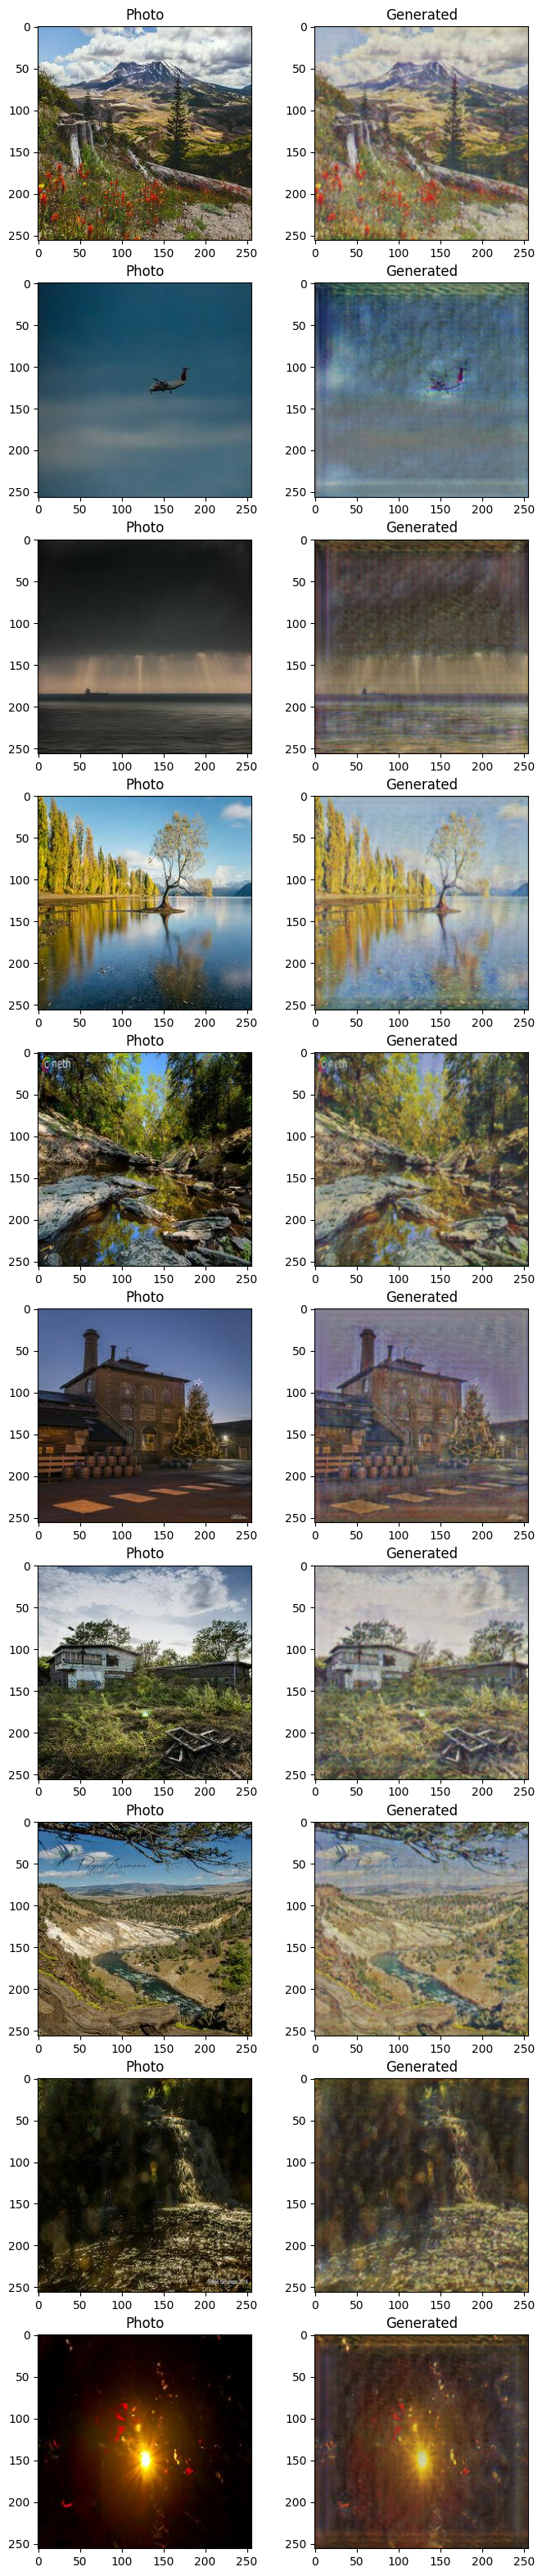

In [29]:
fig, ax = plt.subplots(10, 2, figsize=(8, 40))
for i, photo in enumerate(photo_ds.skip(430).take(10)):
    ax[i,0].set_title("Photo")
    ax[i,0].imshow((photo[0]+1)/2)
    ax[i,1].set_title("Generated")
    ax[i,1].imshow((monet_generator.predict(photo)[0]+1)/2) #maybe add numpy #gan.m_gen(photo, training=False
plt.show()

# Submission #

In [30]:
# for i, photo in enumerate(photo_ds):
#     generated = ((monet_generator(photo, training=False)[0]+1)/2*255).numpy().astype(np.uint8)
#     image = Image.fromarray(generated)
#     image.save("./images/"+str(i)+".jpg", "JPEG")

In [31]:
# import shutil
# shutil.make_archive("images", 'zip', "./images")

# Performance #

In [33]:
pd.set_option('display.max_colwidth', 0)
performance_df = pd.DataFrame({"Change Log": ["original", "original architecture with 1367 additional data, random rotation, random flip and random crop to 224*224 and resize augmentation", "original architecture with 1367 additional data, random rotation, random flip and random crop to 224*224 and resize augmentation",
                                              "vgg-inspired architecture for generator with same augmentation", "deep architecture with same augmentation", "deep architecture with same augmentation", "deep architecture with same augmentation", "deep architecture with same augmentation"], "Epochs":[25, 5, 10, 5, 5, 15, 20, 25], 
                               "Monet Generator Loss":["NA", 2.5088, 2.4502, 5.5410, 2.5827, "NA", 3.1403, 3.2352], "Photo Generator Loss":["NA", 2.6904, 2.6675, 5.9166, 2.7249, "NA", 2.8304, 2.9745], 
                               "Monet Discriminator Loss":["NA", 0.6435, 0.6297, 0.5253, 0.5681, "NA", 0.4558, 0.4195], "Photo Discriminator Loss":["NA", 0.6187, 0.5826, 0.4496, 0.5513, "NA", 0.5341, 0.4826],
                               "MiFID":[73.0476, "NA", "NA", "NA", "NA", "NA", "NA", 61.31156], 
                               "Visual Notes":["big cross-like patterns", "cross-like patterns", "more minute patterns", "color change", "yellow lines in picture", "wrinkly patterns and dots", "painting-like with artificial light spots", "painting"]})
performance_df

Change Log  \
0  original                                                                                                                           
1  original architecture with 1367 additional data, random rotation, random flip and random crop to 224*224 and resize augmentation   
2  original architecture with 1367 additional data, random rotation, random flip and random crop to 224*224 and resize augmentation   
3  vgg-inspired architecture for generator with same augmentation                                                                     
4  deep architecture with same augmentation                                                                                           
5  deep architecture with same augmentation                                                                                           
6  deep architecture with same augmentation                                                                                           
7  deep architecture with same augmentation                                                                                           

   Epochs Monet Generator Loss Photo Generator Loss Monet Discriminator Loss  \
0  25      NA                   NA                   NA                        
1  5       2.5088               2.6904               0.6435                    
2  10      2.4502               2.6675               0.6297                    
3  5       5.541                5.9166               0.5253                    
4  5       2.5827               2.7249               0.5681                    
5  15      NA                   NA                   NA                        
6  20      3.1403               2.8304               0.4558                    
7  25      3.2352               2.9745               0.4195                    

  Photo Discriminator Loss     MiFID  \
0  NA                       73.0476    
1  0.6187                   NA         
2  0.5826                   NA         
3  0.4496                   NA         
4  0.5513                   NA         
5  NA                       NA         
6  0.5341                   NA         
7  0.4826                   61.31156   

                                Visual Notes  
0  big cross-like patterns                    
1  cross-like patterns                        
2  more minute patterns                       
3  color change                               
4  yellow lines in picture                    
5  wrinkly patterns and dots                  
6  painting-like with artificial light spots  
7  painting